In [7]:
%matplotlib inline
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from scipy import signal

In [8]:
import peakutils

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [126]:
(rate,sig) = wav.read("kevin.wav")
mfcc_feat = mfcc(sig,rate)
mfcc_feat.shape

(500, 13)

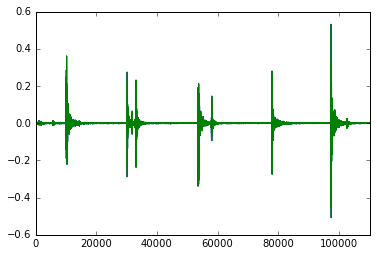

In [127]:
pd.Series(sig[:, 0]).plot()
pd.Series(sig[:, 1]).plot()

In [128]:
rate # 44100

44100

In [20]:
# X, time
t.shape
# Y, frequency in HZ
f.shape

(1565,)

In [146]:
f[70]

12058.59375

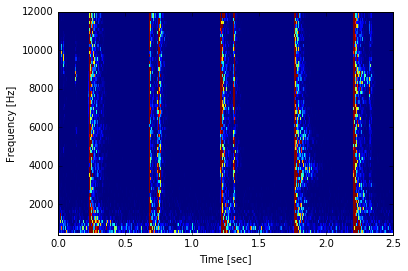

In [130]:
f, t, Sxx = signal.spectrogram(sig[:, 0], rate)
plt.pcolormesh(t, f[3:70], Sxx[3:70, :], norm=None, alpha=1, vmax=1e-8, vmin=0)
plt.ylabel('Frequency [Hz]')
plt.ylim((400, 12000))
plt.xlabel('Time [sec]')
plt.show()

(0, 5)

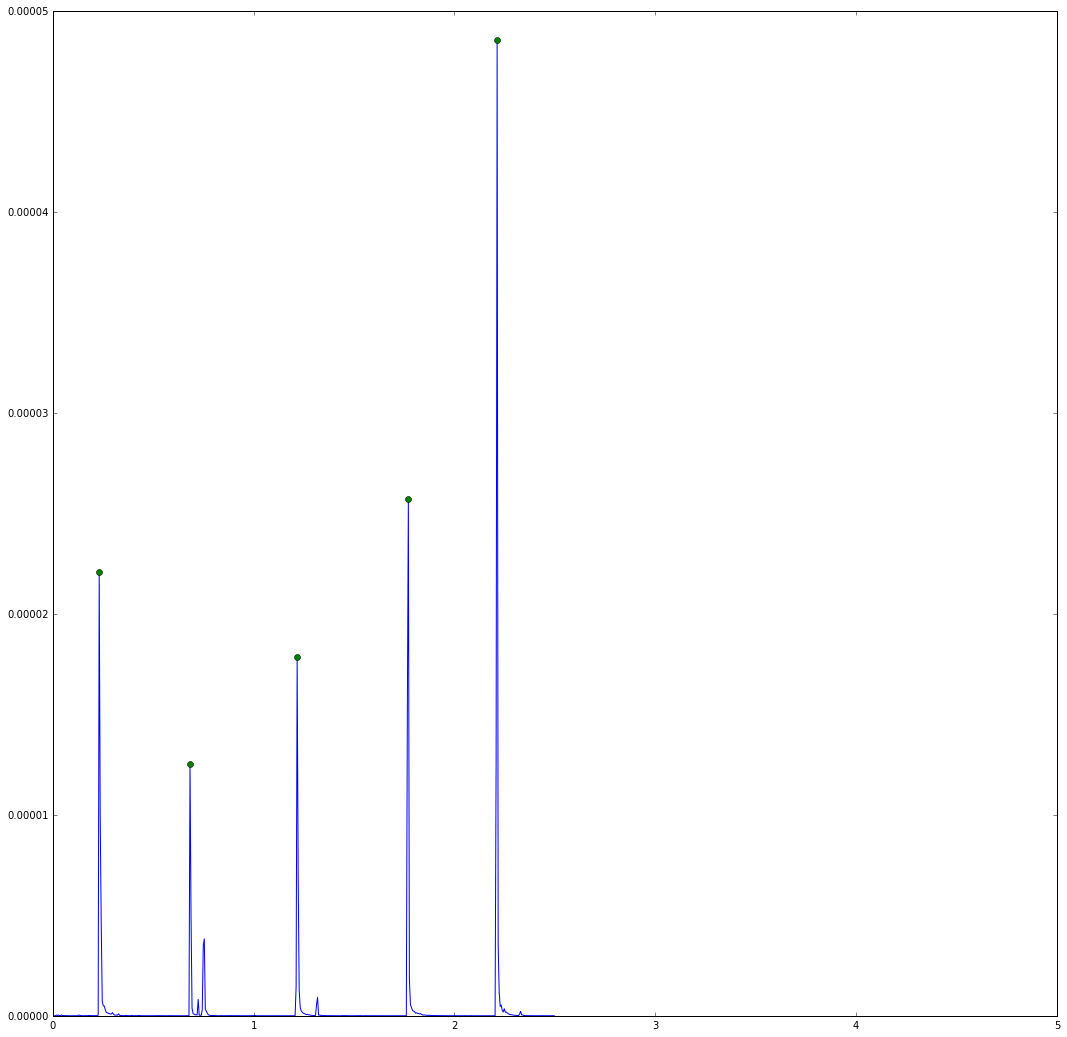

In [134]:
sig_str = np.sum(Sxx[3:70, :], axis=0)
indexes = peakutils.indexes(sig_str, thres=0.1, min_dist=5)
fig = plt.figure(figsize=(18, 18))
plt.plot(t, sig_str)
plt.plot(t[indexes], sig_str[indexes], 'o')
plt.ylim(0, 5e-5)
plt.xlim(0, 5)

(0, 5)

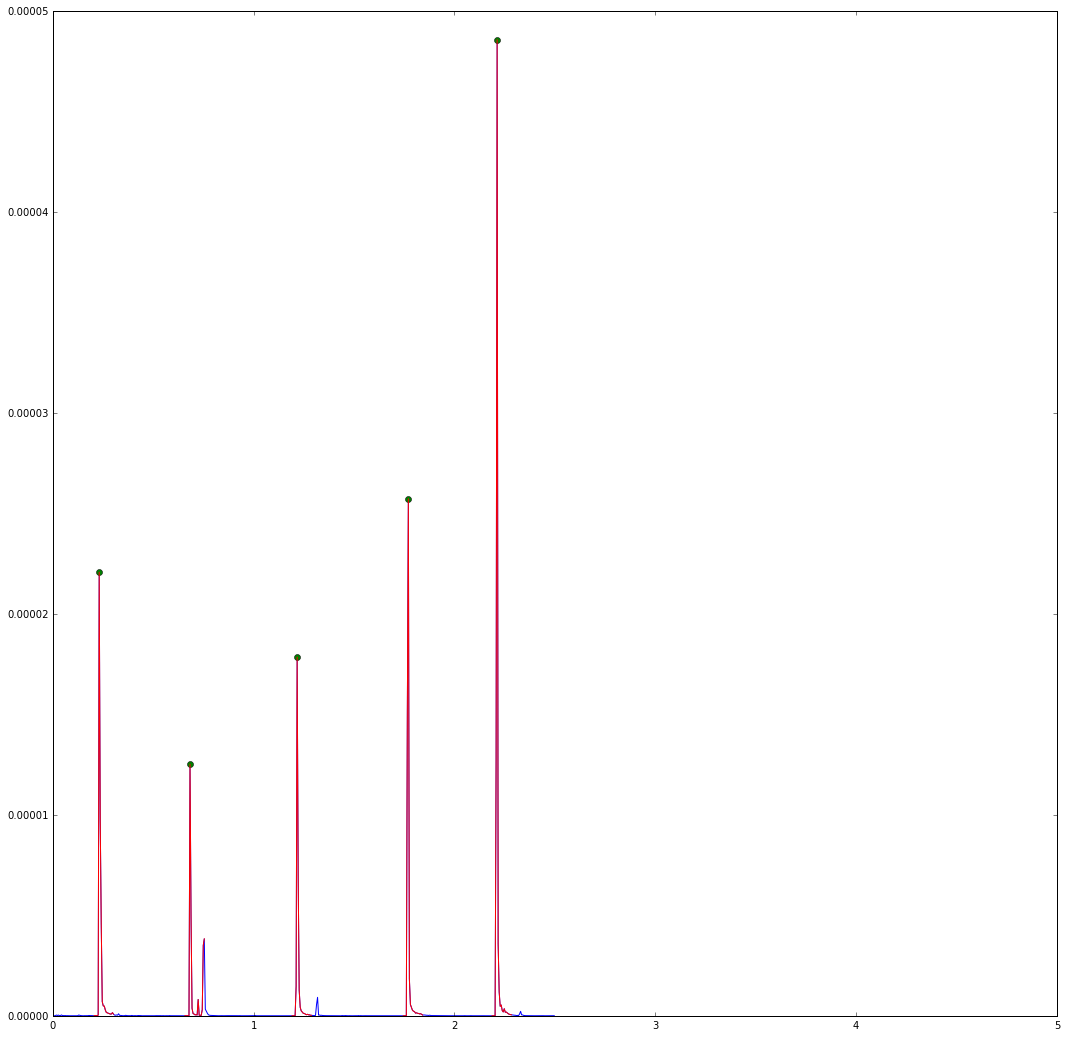

In [142]:
sig_str = np.sum(Sxx[3:70, :], axis=0)
indexes = peakutils.indexes(sig_str, thres=0.1, min_dist=5)
fig = plt.figure(figsize=(18, 18))
plt.plot(t, sig_str)
plt.plot(t[indexes], sig_str[indexes], 'o')

for ind in indexes:
    plt.plot(t[ind - 5: ind + 15], sig_str[ind - 5: ind + 15], 'r')
plt.ylim(0, 5e-5)
plt.xlim(0, 5)

In [117]:
indexes = peakutils.indexes(sig_str, thres=0.01, min_dist=5)
len(indexes)

24

(0, 5)

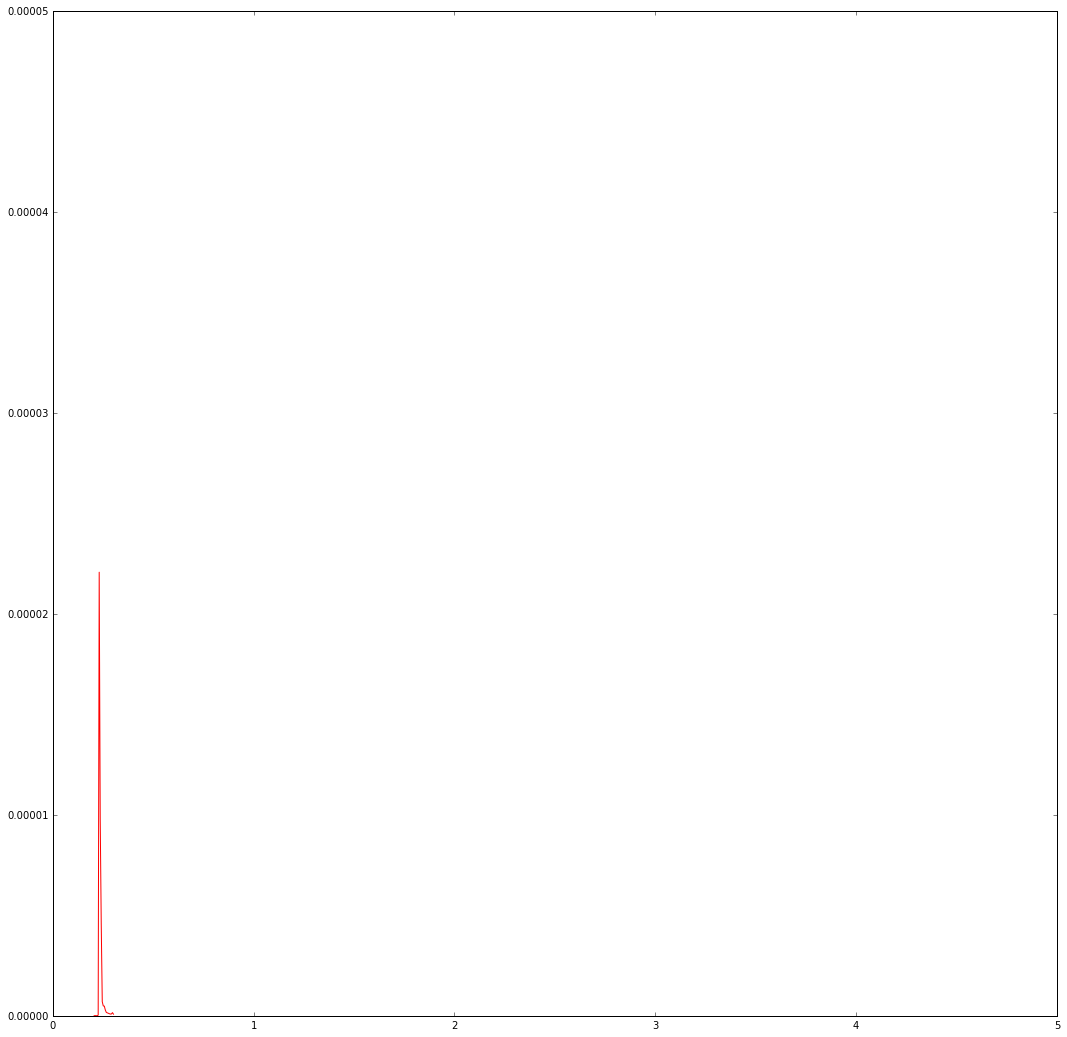

In [140]:
fig = plt.figure(figsize=(18, 18))
# plt.plot(t, sig_str)
plt.ylim(0, 5e-5)
plt.xlim(0, 5)

In [25]:
# Exact line
s = "hello my name is kevin"
len(s)

22

In [90]:
kevin

In [93]:
from vector import vector, plot_peaks

ImportError: No module named vector

In [92]:
len(indexes)

25

In [57]:
sig_str.max()

1.3121477e-05

In [58]:
sig_str.max

<function max>